In [44]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [60]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other);
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self, other):
        other =  other if isinstance(other, Value) else Value(other);
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def __rmul__(self, other):
        return self.__mul__(other)
    def __radd__(self, other):
        return self.__add__(other)
    def __truediv__(self, other):
        return self * other**-1
        # other =  other if isinstance(other, Value) else Value(other);
        # out = Value(self.data / other.data, (self, other), '/')
        # def _backward():
        #     self.grad += 1.0 / other.data * out.grad
        #     other.grad += -self.data / (other.data**2) * out.grad
        # out._backward = _backward
        # return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        # other =  other if isinstance(other, Value) else Value(other);
        # out = Value(self.data ** other.data, (self, other), f'**{other.data}')
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data**(other-1.0)) * out.grad
            # self.grad += other.data * (self.data**(other.data-1.0)) * out.grad
            # other.grad += math.log(self.data) * (self.data**other.data) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
    

In [76]:
from graphviz import Digraph

def trace(root):
    #build a set of all nodes and edgges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, write_to_file=False):
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'}) # LR = left to right
    # save to svg file
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name= uid, label="{ %s | data %.4f | %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    #render to file
    if(write_to_file):
        dot.render("graph", format="svg")
    return dot

In [38]:
# inputs x1, x2
x1 = Value(1.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.2345, label='b')
# output o
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'
o.backward()

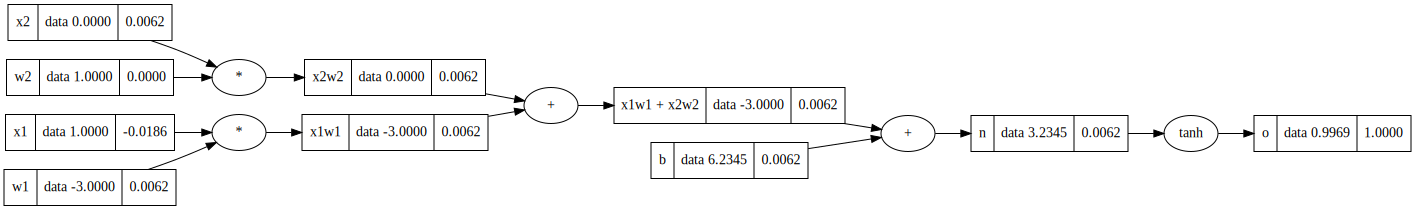

In [39]:
draw_dot(o)

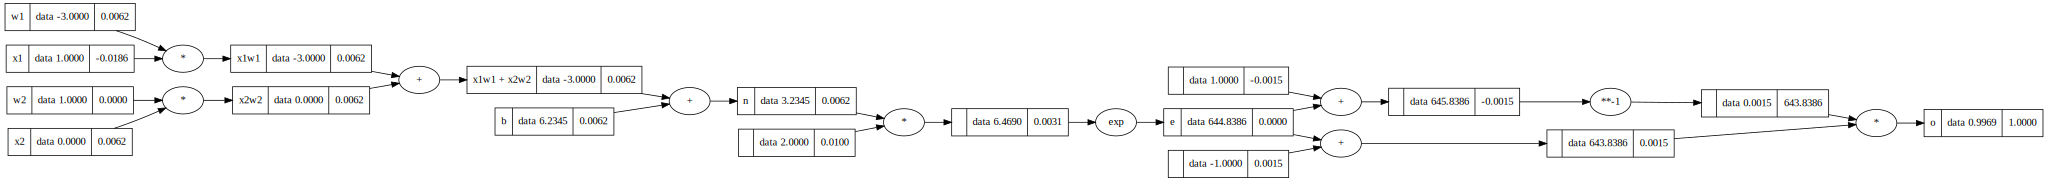

In [40]:
# inputs x1, x2
x1 = Value(1.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias b
b = Value(6.2345, label='b')
# output o
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n: Value = x1w1x2w2 + b
n.label = 'n'
#
e: Value = (2*n).exp(); e.label = 'e'
o = (e - 1.0) / (e + 1.0)
#
o.label = 'o'
o.backward()
draw_dot(o)

In [43]:
import torch

# inputs x1, x2
x1 = torch.tensor(1.0).double(); x1.requires_grad = True;
x2 = torch.tensor(0.0).double(); x2.requires_grad = True;
# weights w1, w2
w1 = torch.tensor(-3.0).double(); w1.requires_grad = True;
w2 = torch.tensor(1.0).double(); w2.requires_grad = True;
# bias b
b = torch.tensor(6.2345).double(); b.requires_grad = True;
# output o
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.996903250471685
------
x1 -0.01855172759696644
x2 0.006183909198988813
w1 0.006183909198988813
w2 0.0


In [62]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1.0, 1.0)) for _ in range(nin)]
        self.b = Value(random.uniform(-1.0, 1.0))
    def __call__(self, x):
        # w*x + b
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [63]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
y = n(x)

In [ ]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 5.0],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

In [ ]:
loss = sum([(yout - ytrue)**2 for ytrue, yout in zip(ys, ypred)])

In [66]:
loss.backward()

In [68]:
n.layers[0].neurons[0].w[0].grad

-0.3953310114202997

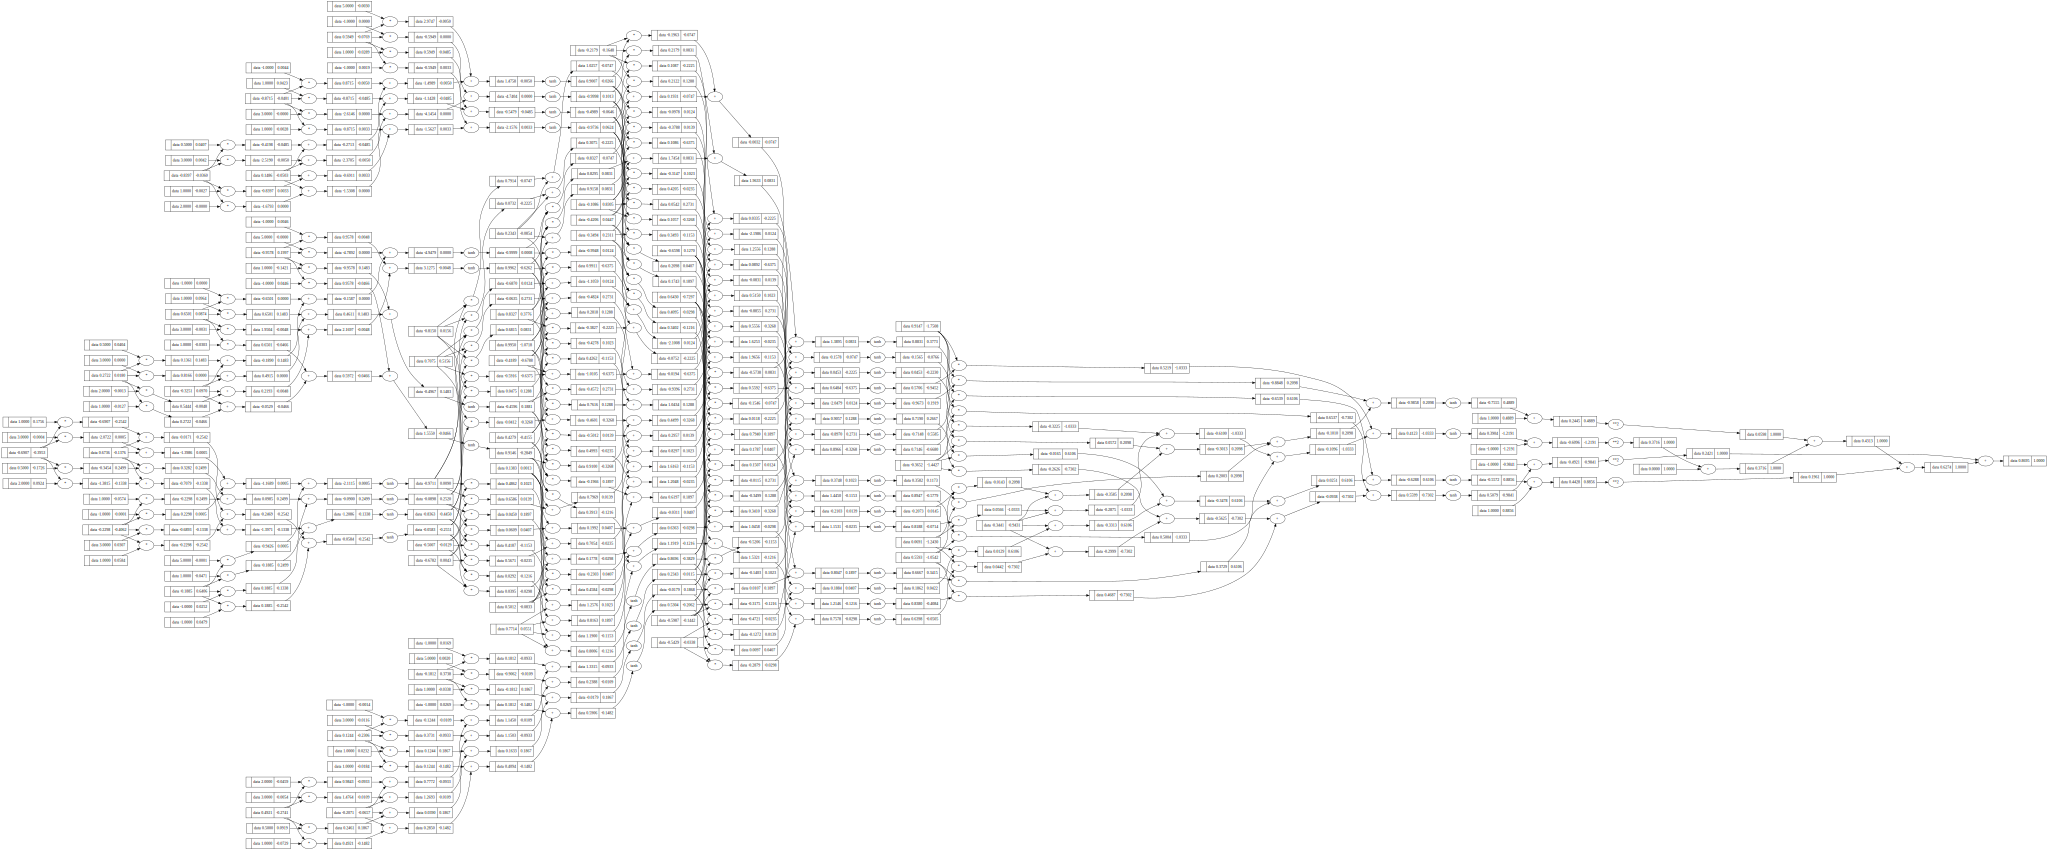

In [77]:
draw_dot(loss)